In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import copy
import torch.nn as nn
import shap
import seaborn as sns

import sys, os, json
sys.path.insert(1, '../../models/Multi-Body')
from multidataset import MultiDataset
from multimodel import Net as Model

In [2]:
#Parameters to change, can change model_type to 'best' or 'last'
modelname = 'MultiBody8-Subjettiness_massTrue_ptTrue_best_baseline'
#modelname = 'MultiBody8-Subjettiness_massTrue_ptTrue_best_tau_x_1_tau_x_1'
model_dict = json.load(open('../../models/Multi-Body/trained_model_dicts/' + modelname.replace("_best", "") + ".json"))
use_jet_pt = model_dict['use_pt']
use_jet_mass = model_dict['use_mass']
tau_x_1 = model_dict['tau_x_1']
N = model_dict['N']
extra_name = model_dict['label']
hidden = list(map(int, model_dict['nodes'].split(',')))
# use_jet_pt = True
# use_jet_mass = True
# tau_x_1 = False
# N = 8
# extra_name = ''

model_type = 'best'
if extra_name != '' and not extra_name.startswith('_'):
    extra_name = '_' + extra_name
if tau_x_1:
    extra_name += '_tau_x_1'

classes = []
if not tau_x_1:
    for i in range(N-1):
        if i != N-2:
            classes.append('tau_'+str(i+1)+'_'+str(0.5))
            classes.append('tau_'+str(i+1)+'_'+str(1))
            classes.append('tau_'+str(i+1)+'_'+str(2))
        else:
            classes.append('tau_'+str(i+1)+'_'+str(1))
            classes.append('tau_'+str(i+1)+'_'+str(2))
    if use_jet_pt:
        classes.append('jet_pt')
    if use_jet_mass:
        classes.append('jet_mass')
else:
    for i in range(N-1):
        classes.append('tau_'+str(i+1)+'_'+str(1))
    if use_jet_pt:
        classes.append('jet_pt')
    if use_jet_mass:
        classes.append('jet_mass')

    
## if hidden = [200, 200, 50], uncomment the following 3 lines
# hidden = [200,200,50]
# extra_name = '_no_fourth_layer'
# tau_x_1 = False

#Testing pat

#model path
model_path = '../../models/Multi-Body/trained_models/MultiBody' + str(N) + '-Subjettiness_mass' +str(use_jet_mass)+\
             '_pt'+str(use_jet_pt)+'_'+ model_type + extra_name

#loading model
model = Model(N, use_jet_pt, use_jet_mass, tau_x_1, hidden).cuda()
model.load_state_dict(torch.load(model_path))
model.eval()

Net(
  (_nn): Sequential(
    (0): Sequential(
      (0): Linear(in_features=22, out_features=200, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=200, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=50, out_features=2, bias=True)
      (1): Identity()
      (2): Identity()
    )
  )
  (softmax): Softmax(dim=1)
)

In [3]:
layers = []
layer_types = []
for layer in model._nn:
    for sl in layer:
        layers.append(sl)
        if type(sl) == nn.Linear:
            layer_types.append('linear')
        elif type(sl) == nn.ReLU:
            layer_types.append('relu')
        elif type(sl) == nn.Dropout:
            layer_types.append('dropout')
        else:
            layer_types.append('other')
        
L = len(layers)
print(layer_types)

['linear', 'relu', 'dropout', 'linear', 'relu', 'dropout', 'linear', 'relu', 'dropout', 'linear', 'relu', 'dropout', 'linear', 'other', 'other']


In [4]:
test_path = '../../datasets/n-subjettiness_data/test_all.npy'
test_set = MultiDataset(test_path, N, use_jet_pt, use_jet_mass, tau_x_1)
data, labels = test_set[:]
bkg_indices = labels[:,0] == 1
sig_indices = labels[:,0] == 0
bkg_data = data[bkg_indices, :]
sig_data = data[sig_indices, :]

A_bkg = [torch.from_numpy(bkg_data).float().cuda()]+[None]*L
A_sig = [torch.from_numpy(sig_data).float().cuda()]+[None]*L
sel_layer_indices = [0] + [ii + 1 for ii in range(L-1) if layer_types[ii] == 'dropout' or (layer_types[ii] == 'linear' and layer_types[ii+1] == 'other')]
print(sel_layer_indices)
for i in range(L):
    #print(layer_types[i])
    A_bkg[i+1] = layers[i].forward(A_bkg[i])
    A_sig[i+1] = layers[i].forward(A_sig[i])

B_bkg = [] # A[0], A[3], A[6], A[9], A[12], A[13][:,col][...,None]]
B_sig = []
for ii, layer_id in enumerate(sel_layer_indices):
    if ii == len(sel_layer_indices) - 1:
        B_bkg.append(A_bkg[layer_id][:,0][...,None])
        B_sig.append(A_sig[layer_id][:,1][...,None])
    else:
        B_bkg.append(A_bkg[layer_id])
        B_sig.append(A_sig[layer_id])
print(len(B_bkg))

[0, 3, 6, 9, 12, 13]
6


In [5]:
def LRPEvaluator(A,B,layers,sel_layer_indices,col,lrp_type='gamma',lrp_param=2,zero_bias=False):
    
    if lrp_type == 'zero':
        rho = lambda p: p                       
        incr = lambda z: z
    elif lrp_type == 'gamma':
        rho = lambda p: p + lrp_param*p.clamp(min=0) 
        incr = lambda z: z
    elif lrp_type == 'epsilon':
        rho = lambda p: p
        incr = lambda z: z+lrp_param
        
    def newlayer(layer,g):
        layer = copy.deepcopy(layer)
        with torch.no_grad():
            try: layer.weight = nn.Parameter(g(layer.weight))
            except AttributeError: pass
            if zero_bias:
                try: nn.init.constant_(layer.bias, 0.0)
                except AttributeError: pass
            else:
                try: layer.bias   = nn.Parameter(g(layer.bias))
                except AttributeError: pass
        return layer
    
    R = [None]*(len(B) - 1) + [B[-1]]
    # Iterate over the layers in reverse order
    for l, layer_id in list(zip(range(0, len(B)-1), sel_layer_indices[:-1]))[::-1]:    
        #B[l] = (B[l+1].data).requires_grad_(True)
        this_layer = layers[layer_id] 
        B[l] = (B[l].data).requires_grad_(True)
        #z = newlayer(model_copy._modules[layer_names[3*l]], rho).forward(B[l]) # setp 1
        z = newlayer(this_layer, rho).forward(B[l]) # setp 1
        if l != len(B) - 2:
            #z = model_copy._modules[layer_names[3*l+1]].forward(z)
            #z = incr(model_copy._modules[layer_names[3*l+2]].forward(z))
            z = layers[layer_id+1].forward(z)
            z = layers[layer_id+2].forward(z)
        else:
            z = incr(z[:,col][...,None])
        #Gets rid of zeroes in denominators
        inds_nz = z != 0
        R1_sum = torch.sum(R[l+1].clone())
        R2_sum_nz = torch.sum(R[l+1][inds_nz].clone())
        R[l+1] = R[l+1].clone()*R1_sum/R2_sum_nz
        z = torch.where(z == torch.FloatTensor([0]).cuda(), torch.FloatTensor([1]).cuda(), z)
        R[l + 1] = torch.where(z == torch.FloatTensor([0]).cuda(), torch.FloatTensor([0]).cuda(), R[l+1])

        s = (R[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = B[l].grad                  # step 3
        R[l] = (B[l]*c).data                                   # step 4
    
    #Plots relevances as normalized
    R[0] = R[0].detach().cpu()
    normal_rel = np.empty_like(R[0])
    #Normalizes relevances for each sample
    normal_rel = (R[0]/np.sum(R[0].detach().numpy(), 1)[:, np.newaxis]).detach().numpy()
    return normal_rel

In [12]:
def removeOutliers(x, outlierConstant=1.5):
    quantiles = np.quantile(x, (0.25, 0.75),axis=0)
    IQR = (quantiles[1]-quantiles[0])*1.5
    result = np.where((x>=quantiles[0]-IQR)&(x<=quantiles[1]+IQR), x, 0)
    
    return result

def relPlotter(normal_rel,classes,options,datatype,save=False,rel4mean=False):
    print('abs_bar')
    normal_rel_no_outlier = removeOutliers(normal_rel)
    plt.figure(figsize=(5,5))
    abs_relevances = np.nanmean(np.abs(normal_rel_no_outlier), 0) #Takes mean across all jets
    df_rel = pd.DataFrame(dict(params=classes, rels=abs_relevances))
    df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
    # creating the abs bar plot
    max_display = 10
    plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
    plt.tight_layout()
    plt.xlabel("Mean |Relevance Score|", fontsize=16)
    if  rel4mean:
        plt.xlabel("|Mean-Behavior Relevance Score|", fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.tick_params(axis='x', which='major', labelsize=16)
    plt.tick_params(axis='y', which='major', labelsize=16)
    if datatype == 'bkg':
        plt.text(0.15, 2, "background", fontsize=16, bbox=dict(boxstyle='Square', facecolor='white'))
    if datatype == 'sig':
        plt.text(0.18, 2, "signal", fontsize=16, bbox=dict(boxstyle='Square', facecolor='white'))
    if save:
        plt.savefig("figures/LRP_MB8S_{}_{}_absbar.png".format(options, datatype),
                    dpi = 150, bbox_inches='tight')
    plt.show()

In [7]:
tag_labels = []
for feat in classes:
    if feat == 'jet_pt':
        tag_labels.append('$p_{T,J}$')
    elif feat == 'jet_mass':
        tag_labels.append('$m_J$')
    else:
        x, y = feat.split('_')[1], feat.split('_')[2]
        tag_labels.append(r'$\tau_' + x + '^{' + y + '}$')

abs_bar


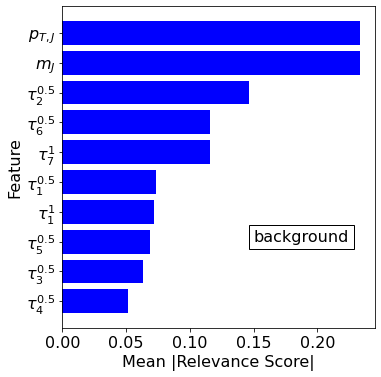

In [8]:
xx = LRPEvaluator(A_bkg,B_bkg,layers,sel_layer_indices,col=0,lrp_type='gamma',lrp_param=2,zero_bias=False)
relPlotter(xx,tag_labels,options=extra_name,datatype='bkg',save=True if "baseline" in extra_name else False)

abs_bar


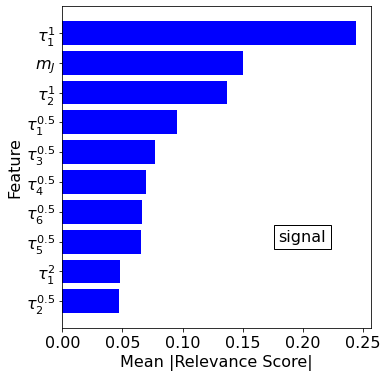

In [13]:
xx = LRPEvaluator(A_sig,B_sig,layers,sel_layer_indices,col=1,lrp_type='gamma',lrp_param=2,zero_bias=False)
relPlotter(xx,tag_labels,options=extra_name,datatype="sig",save=True if "baseline" in extra_name else False)